# Introduction

A notebook that I use to familiarise myself with PyTorch.

The code below shows how to

- compute gradients in a computation graph with PyTorch
- let PyTorch learn how to add (or subtract) two numbers using a Perceptron

# Autograd

## Scalars don't have derivatives

In [1]:
import torch

In [2]:
x = torch.ones(1, requires_grad=True)

In [3]:
x

tensor([1.], requires_grad=True)

In [4]:
print(x)

tensor([1.], requires_grad=True)


In [5]:
type(x)

torch.Tensor

In [6]:
print(x.grad)

None


x is just a scalar that stores the value 1.0.  Therefore, it has no derivative.

## A function has a derivative

In [7]:
x = torch.ones(1, requires_grad=True)
y = 2*x

In [8]:
type(x)

torch.Tensor

In [9]:
type(y)

torch.Tensor

In [10]:
x

tensor([1.], requires_grad=True)

In [11]:
y

tensor([2.], grad_fn=<MulBackward0>)

In [12]:
print(x.grad)

None


The derivative of y with respect to x is not yet computed. First we have to call:

In [13]:
y.backward()

In [14]:
print(x.grad)

tensor([2.])


Note: $\frac{dy}{dx} = 2$

## Another example for automatic gradient computation

In [15]:
x = torch.ones(1, requires_grad=True)
y = 2*x
z = y*y*y

In [16]:
type(x)

torch.Tensor

In [17]:
type(y)

torch.Tensor

In [18]:
type(z)

torch.Tensor

In [19]:
x

tensor([1.], requires_grad=True)

In [20]:
x.item()

1.0

In [21]:
y

tensor([2.], grad_fn=<MulBackward0>)

In [22]:
z

tensor([8.], grad_fn=<MulBackward0>)

In [23]:
z.backward()

In [24]:
z.grad

/home/juebrauer/anaconda3/envs/env_generic/lib/python3.9/site-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/build/aten/src/ATen/core/TensorBody.h:412.)
  return self._grad


In [25]:
y.grad

In [26]:
x.grad

tensor([24.])

$\frac{dz}{dx} = \frac{dz}{dy} * \frac{dy}{dx} = 3y^2 * 2 = 6(2x)^2 = 6*4x^2 = 24x^2$

# Machine learning

## Prepare a Perceptron

We build a Perceptron with 2 inputs, 5 hidden neurons, 1 output neuron

In [27]:
class Perceptron(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        super().__init__()
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, output_size)        
        
    def forward(self, input_vec):
        
        out1 = self.layer1(input_vec)
        out2 = self.layer2(out1)
        return out2        

In [28]:
p = Perceptron(2,5,1)

In [29]:
p

Perceptron(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [30]:
p.layer1.weight

Parameter containing:
tensor([[-0.0157, -0.5818],
        [ 0.4726, -0.5703],
        [-0.1261, -0.5933],
        [-0.2975,  0.7032],
        [-0.6694, -0.5163]], requires_grad=True)

In [31]:
p.layer1.bias

Parameter containing:
tensor([ 0.0024,  0.2170, -0.5582, -0.0945, -0.5301], requires_grad=True)

In [32]:
p.layer2.weight

Parameter containing:
tensor([[-0.0325, -0.0274, -0.2304,  0.2448,  0.4058]], requires_grad=True)

In [33]:
p.layer2.bias

Parameter containing:
tensor([0.2335], requires_grad=True)

## Feedforward with untrained Perceptron

In [34]:
input_vec = torch.tensor([1.0,3.0])

In [35]:
p(input_vec)

tensor([0.1916], grad_fn=<AddBackward0>)

In [36]:
p.forward(input_vec)

tensor([0.1916], grad_fn=<AddBackward0>)

## Train the Perceptron

In [37]:
p = Perceptron(2,5,1)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(p.parameters(), lr=0.001)

In [38]:
type(loss_fn)

torch.nn.modules.loss.MSELoss

In [39]:
type(optimizer)

torch.optim.sgd.SGD

In [40]:
import numpy
x1 = numpy.random.rand()
x2 = numpy.random.rand()
x1,x2

(0.640419033017736, 0.9203310224827085)

In [41]:
def get_ground_truth_output_from_input_tensor(input_vec):
    x1 = input_vec[0].item()
    x2 = input_vec[1].item()
    
    # target is x1+x2
    #return torch.tensor( [x1+x2] )
    
    # target is x1-x2
    return torch.tensor( [x1-x2] )

In [42]:
input_vec = torch.tensor([10,20])

In [43]:
input_vec

tensor([10, 20])

In [44]:
get_ground_truth_output_from_input_tensor( input_vec )

tensor([-10])

In [45]:
p = Perceptron(2,5,1)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(p.parameters(), lr=0.001)

list_of_errors = []
list_of_avg_errors = []

for train_step in range(50000):
    
    if train_step % 10000 == 0:
        print("train_step=", train_step)
    
    # generate a training sample
    x1 = numpy.random.rand()
    x2 = numpy.random.rand()    
    input_vec   = torch.tensor([x1,x2])
    teacher_vec = get_ground_truth_output_from_input_tensor( input_vec )
            
    # forward step
    y_pred = p(input_vec)
    
    # compute loss
    loss = loss_fn(y_pred, teacher_vec)
           
    # save current loss for plotting it later
    error = abs(teacher_vec-y_pred)
    list_of_errors.append( error.item() )
    
    if len(list_of_errors) > 100 :
        list_of_avg_errors.append( numpy.mean(list_of_errors[-100:]) )
    
    # backward step -> computes gradients
    p.zero_grad()
    loss.backward()
    
    # optimizer step -> adapts weights
    optimizer.step()
    
    if False:
        error = abs(teacher_vec-y_pred)
        print( f"teacher={teacher_vec}, predicted={y_pred:} -> error={error}" )

train_step= 0
train_step= 10000
train_step= 20000
train_step= 30000
train_step= 40000


## Plot the loss curve

In [46]:
list_of_avg_errors[:20]

[0.46865434408187867,
 0.4652723515033722,
 0.46586986422538756,
 0.4659604343771935,
 0.4662798321247101,
 0.47691054314374925,
 0.4762894120812416,
 0.4654541026055813,
 0.46817764326930045,
 0.46551164612174034,
 0.459892285913229,
 0.44775319084525106,
 0.4409126679599285,
 0.4418220399320126,
 0.4379262711107731,
 0.4381957127153873,
 0.4380890513956547,
 0.43095683634281157,
 0.43107629239559175,
 0.42891363710165026]

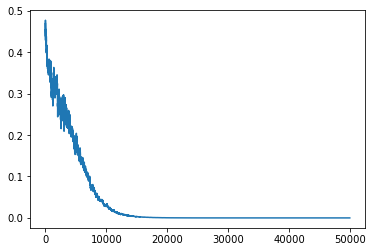

In [47]:
import matplotlib.pyplot as plt

plt.plot( list_of_avg_errors )
plt.show()

## Test the Perceptron

In [48]:
p( torch.tensor( [0.5, 0.5] ) )

tensor([4.3958e-07], grad_fn=<AddBackward0>)

In [49]:
p( torch.tensor( [0.3, 0.2] ) )

tensor([0.1000], grad_fn=<AddBackward0>)

In [50]:
p( torch.tensor( [0.2, 0.3] ) )

tensor([-0.1000], grad_fn=<AddBackward0>)

In [51]:
p( torch.tensor( [1.0, 1.0] ) )

tensor([-3.7625e-06], grad_fn=<AddBackward0>)